In [1]:
import numpy as np
import torchvision
from torch import optim
from torch.nn import init
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import models
from PIL import Image
import torchvision.transforms as transforms
import os
import torch
import torch.nn as nn
from sklearn.metrics import median_absolute_error
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms


In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

testset = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform_test)

valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

100%|██████████| 169M/169M [00:13<00:00, 12.9MB/s]
100%|██████████| 64.3M/64.3M [00:20<00:00, 3.08MB/s]


In [3]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 100)
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 15
losses = []

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 185MB/s]


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = model.to(device)

Using device: cuda


Epoch [1/15], Loss: 3.8028, Accuracy: 0.1354


Epoch [2/15], Loss: 3.1193, Accuracy: 0.2355


Epoch [3/15], Loss: 2.5445, Accuracy: 0.3354


Epoch [4/15], Loss: 2.5036, Accuracy: 0.3448


Epoch [5/15], Loss: 2.1819, Accuracy: 0.4116


Epoch [6/15], Loss: 2.0526, Accuracy: 0.4429


Epoch [7/15], Loss: 1.9074, Accuracy: 0.4723


Epoch [8/15], Loss: 1.8107, Accuracy: 0.4957


Epoch [9/15], Loss: 1.7158, Accuracy: 0.5173


Epoch [10/15], Loss: 1.6367, Accuracy: 0.5358


Epoch [11/15], Loss: 1.5441, Accuracy: 0.5600


Epoch [12/15], Loss: 1.4896, Accuracy: 0.5712


Epoch [13/15], Loss: 1.3970, Accuracy: 0.5945


Epoch [14/15], Loss: 1.3313, Accuracy: 0.6117


Epoch [15/15], Loss: 1.2667, Accuracy: 0.6268


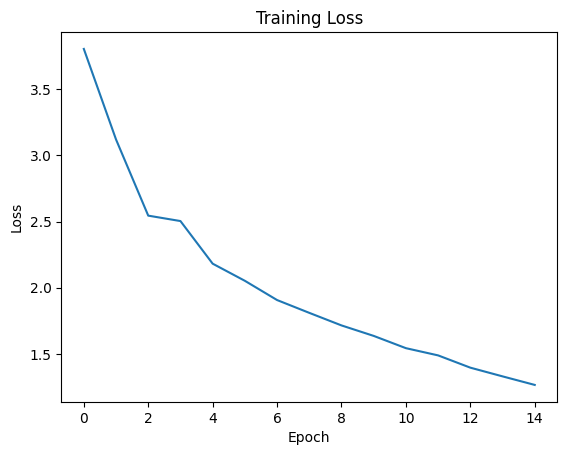

In [7]:
for epoch in range(epochs):
    epoch_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in tqdm(trainloader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False):

        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criteria(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    accuracy = correct_predictions / total_samples
    epoch_loss /= len(trainloader)
    losses.append(epoch_loss)

    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}')

plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [9]:
model.eval()
valid_loss = 0.0
correct_val = 0
total_val = 0

with torch.no_grad():
    for inputs, labels in valloader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criteria(outputs, labels)
        valid_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_val += labels.size(0)
        correct_val += (predicted == labels).sum().item()

valid_loss /= len(valloader)
valid_accuracy = correct_val / total_val

print(f"\nValidation results -> Loss: {valid_loss:.4f}, Accuracy: {valid_accuracy:.4f}")



Validation results -> Loss: 1.1280, Accuracy: 0.6670
